In [95]:
import util.utils as utils

percentage = 0
rand_seed = 42

df_result = utils.get_binary(percentage, rand_seed)
df_text = utils.get_text(percentage, rand_seed)

display(df_text)    
display(df_result)

,TRANSCRIPT_text
ID,
475,synch introv4confirmation hi im ellie thanks f...
386,synch introv4confirmation hi im ellie thanks f...
361,hi im ellie thanks for coming in today i was c...
492,synch introv4confirmation hi im ellie thanks f...
414,sync introv4confirmation hi im ellie thanks fo...
...,...
464,sync introv4confirmation hi im ellie thanks fo...
420,synch introv4confirmation hi im ellie thanks f...
334,hi im ellie thanks for coming in today i was c...


,PHQ_Binary
ID,
475,0
386,1
361,0
492,0
414,1
...,...
464,0
420,0
334,0


### preprocessing

In [96]:
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

def text_preprocessing(text):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df_text['TRANSCRIPT_text'] = df_text['TRANSCRIPT_text'].apply(text_preprocessing)

display(df_text)

[nltk_data] Downloading package stopwords to /Users/karlo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/karlo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,TRANSCRIPT_text
ID,
475,synch introv4confirmation hi im ellie thanks c...
386,synch introv4confirmation hi im ellie thanks c...
361,hi im ellie thanks coming today created talk p...
492,synch introv4confirmation hi im ellie thanks c...
414,sync introv4confirmation hi im ellie thanks co...
...,...
464,sync introv4confirmation hi im ellie thanks co...
420,synch introv4confirmation hi im ellie thanks c...
334,hi im ellie thanks coming today created talk p...


### EDA

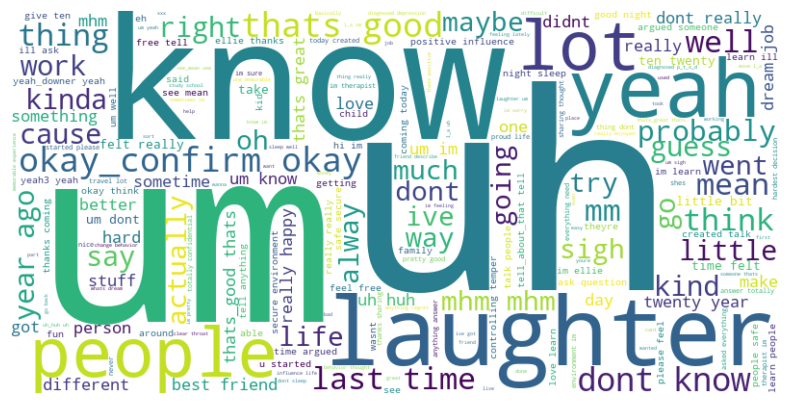

In [97]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud

# Word Cloud for the text data
text = " ".join(df_text['TRANSCRIPT_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


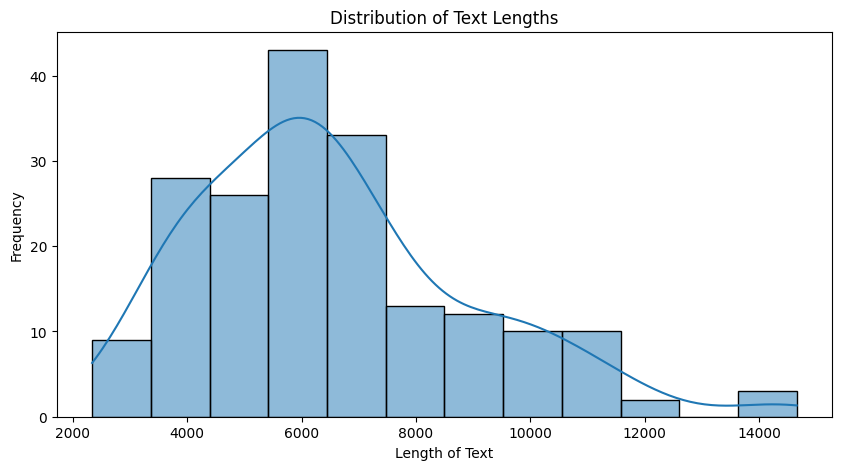

In [98]:
import seaborn as sns

# Length of words
X_train_lengths = df_text['TRANSCRIPT_text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(X_train_lengths, kde=True)
plt.title('Distribution of Text Lengths')
plt.xlabel('Length of Text')
plt.ylabel('Frequency')
plt.show()


[nltk_data] Downloading package punkt to /Users/karlo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


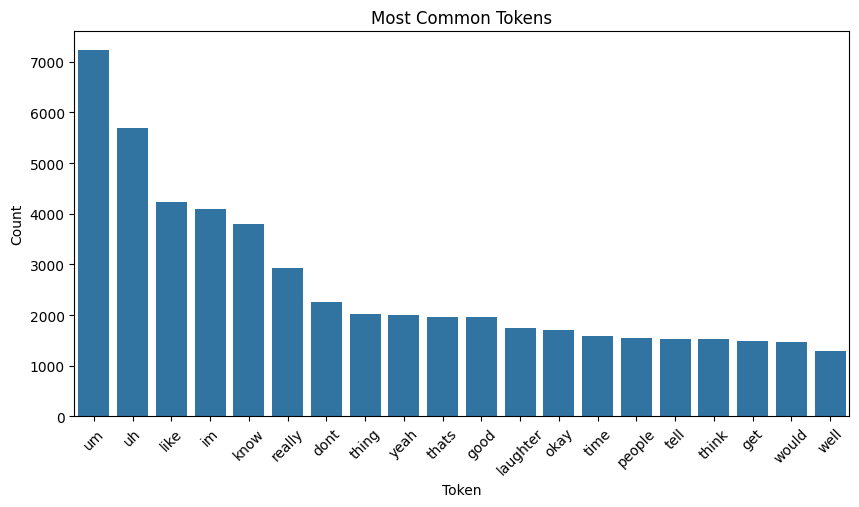

In [99]:
from collections import Counter
import pandas as pd

# Most common tokens
nltk.download('punkt')
all_tokens = nltk.word_tokenize(text)
common_tokens = Counter(all_tokens).most_common(20)

tokens_df = pd.DataFrame(common_tokens, columns=['Token', 'Count'])

plt.figure(figsize=(10, 5))
sns.barplot(data=tokens_df, x='Token', y='Count')
plt.title('Most Common Tokens')
plt.xlabel('Token')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


### train test split

In [100]:
from sklearn.model_selection import train_test_split

df = pd.merge(df_text, df_result, on="ID")

X_train, X_test, y_train, y_test = train_test_split(df['TRANSCRIPT_text'], df['PHQ_Binary'], test_size=0.2,random_state=rand_seed)

### pipeline & hyperparameter tuning

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# Create a pipeline with TF-IDF and a classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2), stop_words='english')),  # Using bigrams
    ('clf', RandomForestClassifier(random_state=rand_seed))
])

# Hyperparameter tuning using Grid Search
param_grid = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__min_df': [1, 2],
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [None, 10, 20]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words='english')),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 10, 20],
                         'clf__n_estimators': [100, 200],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__min_df': [1, 2]},
             scoring='accuracy')

### evaluation

y_pred: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]
y_test: [0 0 0 1 0 0 0 1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0
 0]
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.96      0.83        27
           1       0.50      0.09      0.15        11

    accuracy                           0.71        38
   macro avg       0.61      0.53      0.49        38
weighted avg       0.66      0.71      0.63        38


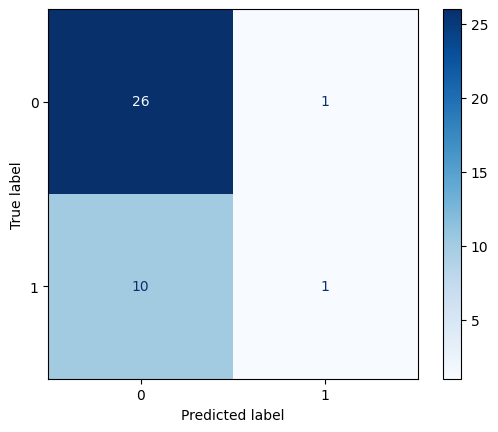

In [102]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = grid_search.predict(X_test)

y_test = y_test.to_numpy()
# Debug: Check the shapes and types of y_pred
print(f'y_pred: {y_pred}')
print(f'y_test: {y_test}')

# Generate and display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Generate and display confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=grid_search.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

